In [1]:
def hama_response(N):
    filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--00000.dat'
    time,h = np.loadtxt(filename,unpack=True)
    ids = np.random.randint(1,300,size=(N-1,1))
    for id in ids:
        filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--%05i.dat' % id
        time,hi = np.loadtxt(filename,unpack=True)
        h = np.row_stack((h,hi))
    return time,h

In [2]:
def sample_distribution(axis,pde,N):
    #this function takes in a sampling axis and a corresponding distribution and produce indices of N samples. 
    """
    fig = plt.figure()
    plt.plot(axis,pde)
    plt.grid(True)
    plt.title('PDE')
   """ 
    ids=np.empty([0])
    while ids.size<=N:
        for i in range(pde.size):
            if np.random.choice([1,0], p=[pde[i],1-pde[i]]) == 1:
                ids = np.append(ids,i)
        ids = np.unique(ids)
    ids = ids.astype(int)
    ids = np.resize(ids,(N,1))
    return axis[ids]

In [3]:
def generate_sparse_convolmatrix(havg):
    hsparse = sparse.lil_matrix((havg.size,havg.size))
    for i in range(havg.size-1):
        hsparse[i,:(i+1)]=havg[i+1:0:-1]
    return hsparse

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/scipy/signal/waveforms.py:674: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif idx == 'mid':


<IPython.core.display.Javascript object>


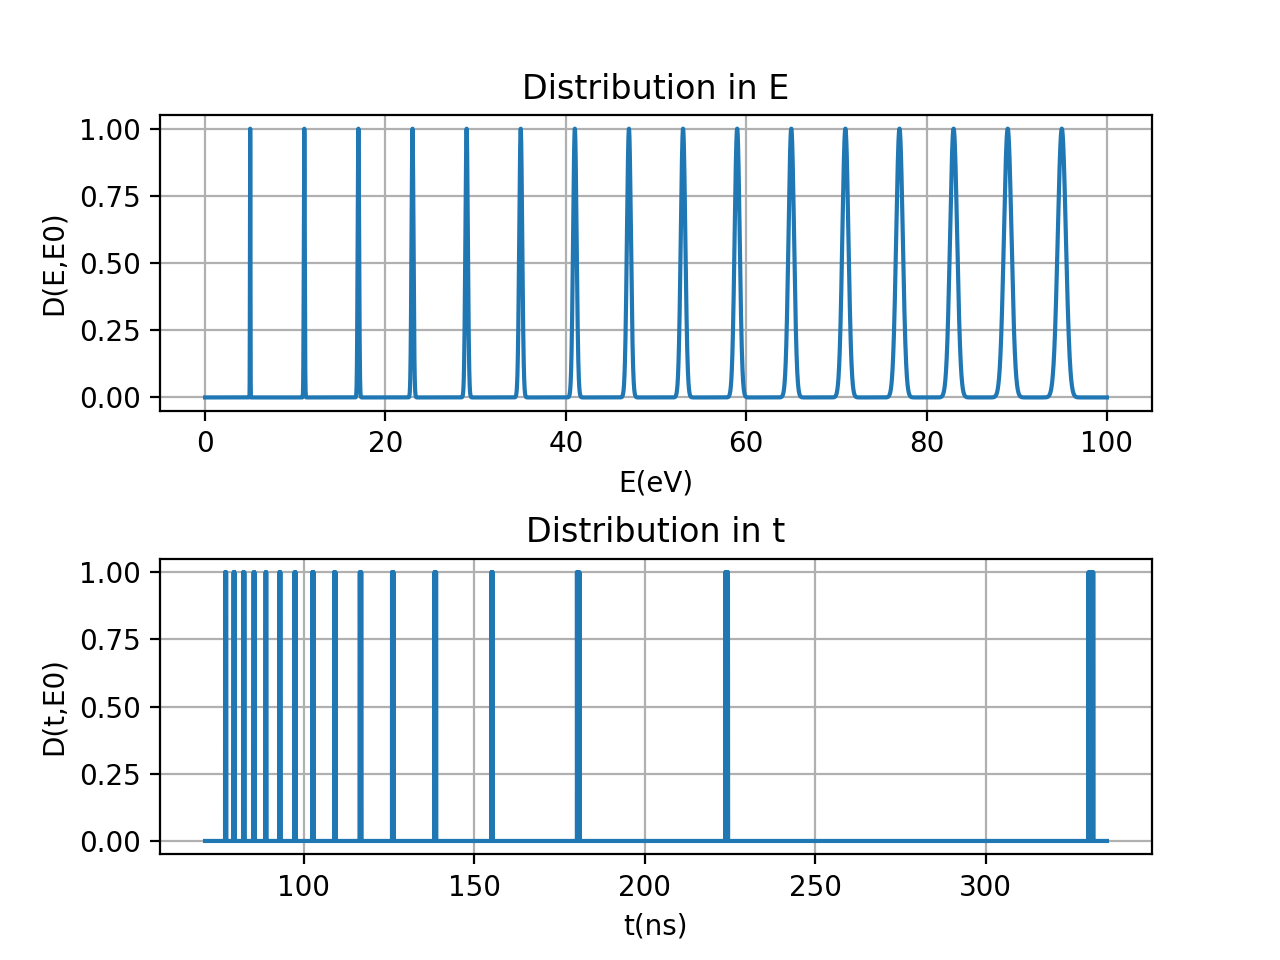

In [4]:
%matplotlib notebook

"""Target in this cell is to sample energies according to an energy distribution with the change in central energy.
Also get the time corresponding time of arrivals(TOAs)."""

from buildwaveforms import energy2time
import numpy as np
from scipy.signal import unit_impulse
import matplotlib.pyplot as plt

E0i = 5.0  #eV
E0f = 95.0 #eV
delta_E0i = 1.0e-4 #ev
delta_E0f = 0.4 #eV
N_E0_pts = 16  # no. of distributions with different E0s(central energies)

E0 = np.linspace(E0i,E0f,N_E0_pts)
E0 = np.resize(E0,(N_E0_pts,1))

delta_E = (((delta_E0f-delta_E0i)/E0f**2)*(E0**2)) + delta_E0i # quadratic estimate(will be modified soon)
delta_E = np.resize(delta_E,(N_E0_pts,1))

#define the energy axis and energy distribution
Ei = 0  #eV
Ef = 100 #eV
N_E_pts = 10000
E = np.linspace(Ei,Ef,N_E_pts)
E_dist = np.exp(-(E-E0)**2/delta_E)

N_E_sam = 5
E_rand = sample_distribution(E,E_dist[0],N=N_E_sam)
for i in range(1,N_E0_pts):
    E_rand = np.append(E_rand,sample_distribution(E,E_dist[i],N=N_E_sam))

E_dist = np.sum(E_dist,axis=0)  
time_TOA = np.resize(energy2time(E_rand),(N_E0_pts*N_E_sam,1))
#print time_TOA

#find the hit indices on time axis
timeaxis_TOA = np.linspace(min(time_TOA)-5,max(time_TOA)+5,10000)
ids=np.empty([0])
count = 0
resol = timeaxis_TOA[1]-timeaxis_TOA[0]
for i in range(timeaxis_TOA.size-1,0,-1):
    if count<time_TOA.size:
        t = int(time_TOA[count])
        fr = time_TOA[count]-t
        if t==int(timeaxis_TOA[i]):
            ids = np.append(ids,i+int(fr/resol))
            count +=1
ids = ids.astype(int)
s_TOA = unit_impulse(timeaxis_TOA.shape,ids)

plt.subplots_adjust(hspace=0.5)
ax1 = plt.subplot(211)
ax1.set_title('Distribution in E')
ax1.plot(E,E_dist)
ax1.set_xlabel('E(eV)')
ax1.set_ylabel('D(E,E0)')
ax1.grid(True)

ax2 = plt.subplot(212)
ax2.set_title('Distribution in t')
ax2.plot(timeaxis_TOA,s_TOA)
ax2.set_xlabel('t(ns)')
ax2.set_ylabel('D(t,E0)')
ax2.grid(True)

In [16]:
%matplotlib notebook

import numpy as np
from scipy.signal import hilbert
from scipy import sparse
import matplotlib.pyplot as plt
import time

timeaxis, h = hama_response(N_E_sam)
havg = np.mean(h,axis=0)
havg = havg[havg.size/2:]

#rescale timeaxis and havg
rescale_pts = int(((((max(time_TOA)-(min(time_TOA))*1e-9)/(timeaxis[-1]-timeaxis[0]))*timeaxis.size)
timeaxis_new = np.linspace((min(time_TOA)-5)*1e-9,(max(time_TOA)+5)*1e-9,rescale_pts)

nzeros = np.zeros(rescale_pts-timeaxis.size)
havg = np.append(havg,nzeros)
"""
havg = np.insert(havg,0,nzerosl)
if (N_E_sam*N_E0_pts)%2 ==0:
    havg = np.append(havg,0)"""
    
thr = []
frac =0.05
havg_im = np.imag(hilbert(havg))
snr = np.abs(havg)**2+np.abs(havg_im)**2
for i in range(havg.size):
    thr.append(frac*max(snr))

havg_mod = np.zeros(havg.size)
for i in range(havg.size):
    if snr[i]>=thr[0]:
        havg_mod[i] = havg[i]

#generate signal

ids=np.empty([0])
count = 0
resol = (timeaxis_new[1]-timeaxis_new[0])*1e9
for i in range(timeaxis_new.size-1,0,-1):
    if count<time_TOA.size:
        t = int(time_TOA[count])
        fr = time_TOA[count]-t
        if t==int(timeaxis_new[i]*1e9):
            ids = np.append(ids,i+int(fr/resol))
            count +=1
ids = ids.astype(int)
s = unit_impulse(timeaxis_new.shape,ids)

#generate sparse convolution matrix
start = time.time()

hsparse = generate_sparse_convolmatrix(havg_mod)

s_cpy = sparse.lil_matrix((1,s.size))
s_cpy[:] = s[:]
y_mod = (hsparse.tocsr()*s_cpy.tocsr().transpose())

end = time.time()
print 'Time elapsed= %i ms'%((end - start)*1000)

ax = plt.subplot(111)
ax.set_title('Convoluted Signal Output')
ax.plot(timeaxis_new*1e9,s)
ax.plot(timeaxis_new*1e9,y_mod.todense())
ax.set_xlabel('t(ns)')
ax.set_ylabel('V(t,E0)')
ax.grid(True)

ValueError: dimension mismatch

In [20]:
havg.size

24849

In [18]:
s.shape

(26849,)

In [35]:
rescale_pts = int((max(time_TOA)-(min(time_TOA))*1e-9/(timeaxis[-1]-timeaxis[0]))*timeaxis.size)
print rescale_pts

1319754
